In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import os


In [9]:

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# --- 1. The Neural Network Model ---
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        # Architecture: 2 inputs -> 5 layers of 20 neurons -> 1 output
        self.net = nn.Sequential(
            nn.Linear(2, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 20), nn.Tanh(),
            nn.Linear(20, 1)
        )

    def forward(self, x, y):
        inputs = torch.cat([x, y], dim=1)
        return self.net(inputs)


Running on: cpu


In [ ]:

# --- 2. Physics & Data Generation Functions ---

def compute_derivatives(model, x, y):
    """
    Helper to compute V and its derivatives (first and second)
    needed for PDE residuals and Neumann BCs.
    """
    x.requires_grad = True
    y.requires_grad = True
    V = model(x, y)

    # First derivatives
    grads = torch.autograd.grad(V, [x, y], grad_outputs=torch.ones_like(V),
                                create_graph=True, retain_graph=True)
    dV_dx, dV_dy = grads[0], grads[1]

    # Second derivatives
    d2V_dx2 = torch.autograd.grad(dV_dx, x, grad_outputs=torch.ones_like(dV_dx),
                                  create_graph=True, retain_graph=True)[0]
    d2V_dy2 = torch.autograd.grad(dV_dy, y, grad_outputs=torch.ones_like(dV_dy),
                                  create_graph=True, retain_graph=True)[0]

    return V, dV_dx, dV_dy, d2V_dx2, d2V_dy2

def get_boundary_data(N_b, L, Vmax, k_vals, bc_type_right='dirichlet'):
    """
    Generates training data for the 4 boundaries.
    bc_type_right: 'dirichlet' or 'neumann' (for Task 2)
    """
    k1, k2, k3, k4 = k_vals

    # -- Coordinates --
    # Left (-L, y), Right (L, y), Bottom (x, -L), Top (x, L)
    y_side = torch.rand(N_b, 1) * 2 * L - L
    x_side = torch.ones_like(y_side)

    x_flat = torch.rand(N_b, 1) * 2 * L - L
    y_flat = torch.ones_like(x_flat)

    # 1. Left Boundary (x = -L) - Dirichlet
    x_l = -L * x_side
    y_l = y_side
    v_l = Vmax * torch.sin(k1 * np.pi * (y_l + L) / (2 * L))

    # 2. Right Boundary (x = L) - Dirichlet OR Neumann
    x_r = L * x_side
    y_r = y_side

    if bc_type_right == 'dirichlet':
        # Standard value assignment
        target_r = Vmax * torch.sin(k3 * np.pi * (y_r + L) / (2 * L))
    else:
        # For Neumann (Task 2), target is the GRADIENT value.
        # C++ code implies dV/dx = 0 (v[N-1] = v[N-2])
        target_r = torch.zeros_like(y_r)

    # 3. Bottom Boundary (y = -L) - Dirichlet
    x_b = x_flat
    y_b = -L * y_flat
    v_b = Vmax * torch.sin(k4 * np.pi * (x_b + L) / (2 * L))

    # 4. Top Boundary (y = L) - Dirichlet
    x_t = x_flat
    y_t = L * y_flat
    v_t = Vmax * torch.sin(k2 * np.pi * (x_t + L) / (2 * L))

    # Package into a dictionary for easier handling in the training loop
    data = {
        'left': (x_l.to(device), y_l.to(device), v_l.to(device)),
        'right': (x_r.to(device), y_r.to(device), target_r.to(device)),
        'bottom': (x_b.to(device), y_b.to(device), v_b.to(device)),
        'top': (x_t.to(device), y_t.to(device), v_t.to(device))
    }
    return data

def get_collocation_points(N_c, L):
    x_c = (torch.rand(N_c, 1) * 2 * L - L).to(device)
    y_c = (torch.rand(N_c, 1) * 2 * L - L).to(device)
    return x_c, y_c


In [ ]:

# --- 3. Modular Training Function ---

def run_task(task_name, Arho, k_vals, bc_type_right, epochs=6000):
    print(f"\n--- Running {task_name} ---")
    print(f"Params: Arho={Arho}, k={k_vals}, Right BC={bc_type_right}")

    # Physics constants
    L = 4.0
    epsilon = 1.0
    Vmax = 1.0

    model = PINN().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_history = []

    for epoch in range(epochs):
        optimizer.zero_grad()

        # --- A. Boundary Loss ---
        bc_data = get_boundary_data(200, L, Vmax, k_vals, bc_type_right)
        loss_bc = 0.0

        # Dirichlet Boundaries (Left, Top, Bottom)
        for side in ['left', 'top', 'bottom']:
            xb, yb, vb_target = bc_data[side]
            vb_pred = model(xb, yb)
            loss_bc += torch.mean((vb_pred - vb_target)**2)

        # Right Boundary (Dirichlet or Neumann)
        xb, yb, target_r = bc_data['right']
        if bc_type_right == 'dirichlet':
            vb_pred = model(xb, yb)
            loss_bc += torch.mean((vb_pred - target_r)**2)
        else:
            # Neumann: Calculate dV/dx at boundary and compare to target (0)
            # We must use compute_derivatives to get gradients
            _, dV_dx, _, _, _ = compute_derivatives(model, xb, yb)
            loss_bc += torch.mean((dV_dx - target_r)**2)

        # --- B. PDE Residual Loss ---
        xc, yc = get_collocation_points(2000, L)
        _, _, _, d2V_dx2, d2V_dy2 = compute_derivatives(model, xc, yc)

        # Charge Density Equation
        rho = Arho * xc * yc * torch.exp(-(xc**2 + yc**2))

        # Residual = Laplacian(V) + rho/epsilon
        residual = d2V_dx2 + d2V_dy2 + (rho / epsilon)
        loss_pde = torch.mean(residual**2)

        # --- Total Loss ---
        total_loss = loss_bc + loss_pde
        total_loss.backward()
        optimizer.step()

        loss_history.append(total_loss.item())

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss {total_loss.item():.5f} (BC={loss_bc.item():.5f}, PDE={loss_pde.item():.5f})")

    # --- Saving Results ---
    save_results(model, loss_history, task_name, L)

def save_results(model, history, task_name, L):
    # 1. Generate Grid Prediction
    N_plot = 100
    x_np = np.linspace(-L, L, N_plot)
    y_np = np.linspace(-L, L, N_plot)
    X, Y = np.meshgrid(x_np, y_np)

    x_flat = torch.tensor(X.flatten(), dtype=torch.float32).unsqueeze(1).to(device)
    y_flat = torch.tensor(Y.flatten(), dtype=torch.float32).unsqueeze(1).to(device)

    with torch.no_grad():
        V_pred = model(x_flat, y_flat).cpu().numpy().reshape(N_plot, N_plot)

    # 2. Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Potential Map
    c1 = ax[0].imshow(V_pred, extent=[-L, L, -L, L], origin='lower', cmap='seismic')
    ax[0].set_title(f'{task_name}: Potential V(x,y)')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    plt.colorbar(c1, ax=ax[0])

    # Convergence
    ax[1].plot(history)
    ax[1].set_yscale('log')
    ax[1].set_title(f'{task_name}: Loss Convergence')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Total Loss (MSE)')
    ax[1].grid(True, which="both", ls="-", alpha=0.5)

    # Save
    filename = f"PINN_result_{task_name}.png"
    plt.tight_layout()
    plt.savefig(filename)
    print(f"Saved plot to {filename}")
    plt.show()
    plt.close()



--- Running Task1 ---
Params: Arho=0.0, k=(1, -1, 1, -1), Right BC=dirichlet
Epoch 0: Loss 2.09834 (BC=2.09810, PDE=0.00024)
Epoch 1000: Loss 0.00192 (BC=0.00012, PDE=0.00180)
Epoch 2000: Loss 0.00103 (BC=0.00016, PDE=0.00086)
Epoch 3000: Loss 0.00176 (BC=0.00120, PDE=0.00056)
Epoch 4000: Loss 0.00065 (BC=0.00017, PDE=0.00048)
Epoch 5000: Loss 0.00050 (BC=0.00012, PDE=0.00038)
Saved plot to PINN_result_Task1.png

--- Running Task2_Neumann ---
Params: Arho=0.0, k=(1, -1, 1, -1), Right BC=neumann
Epoch 0: Loss 1.99104 (BC=1.99097, PDE=0.00007)
Epoch 1000: Loss 0.00407 (BC=0.00145, PDE=0.00262)
Epoch 2000: Loss 0.00165 (BC=0.00101, PDE=0.00064)
Epoch 3000: Loss 0.00092 (BC=0.00067, PDE=0.00025)
Epoch 4000: Loss 0.00073 (BC=0.00056, PDE=0.00017)
Epoch 5000: Loss 0.00059 (BC=0.00047, PDE=0.00011)
Saved plot to PINN_result_Task2_Neumann.png

--- Running Task4a ---
Params: Arho=1.0, k=(0, 0, 0, 0), Right BC=dirichlet
Epoch 0: Loss 0.01171 (BC=0.01015, PDE=0.00155)
Epoch 1000: Loss 0.00002 (B

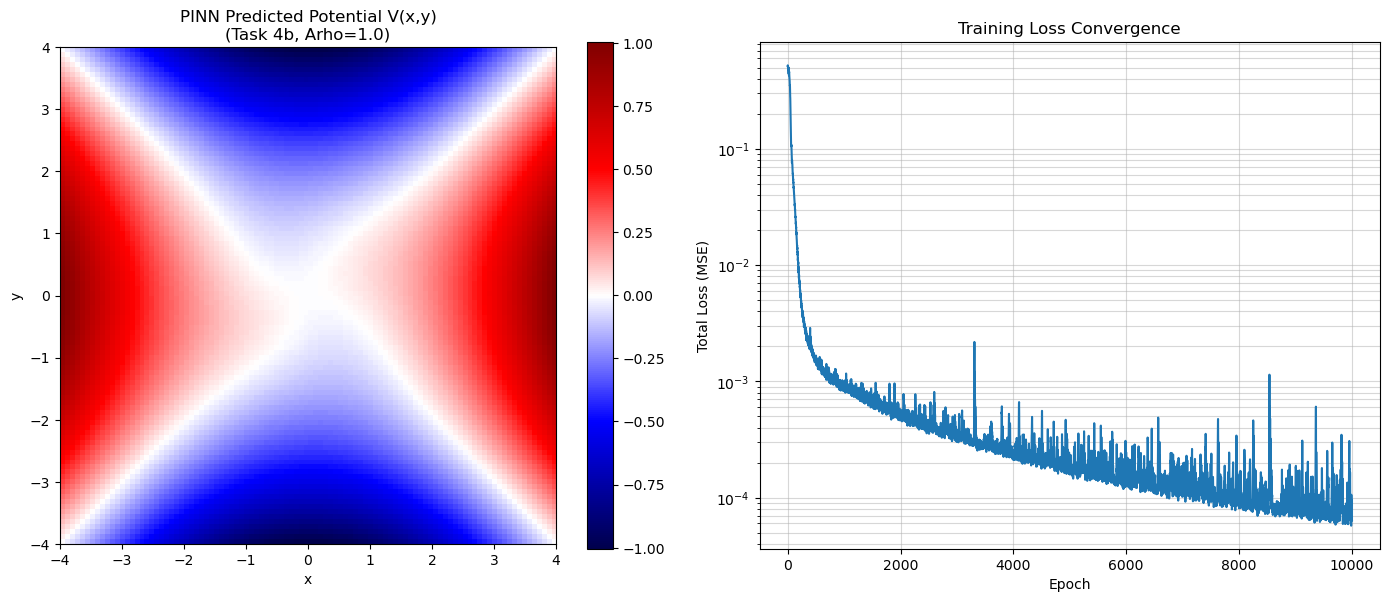

Training complete. You can see that without a mesh, the Neural Network
has learned the complex potential distribution solely from the
boundary equations and the charge density formula.


In [ ]:

# --- 4. Main Execution ---

if __name__ == "__main__":
    # Parameters from C++ code [cite: 34, 107, 217]

    # Task 1: Laplace (Arho=0), Dirichlet
    # k values: 1, -1, 1, -1 (Left, Top, Right, Bottom mappings roughly)
    run_task(task_name="Task1",
             Arho=0.0,
             k_vals=(1, -1, 1, -1),
             bc_type_right='dirichlet')

    # Task 2: Laplace (Arho=0), Neumann on Right
    # Same k values, but right boundary is overridden by Neumann logic
    run_task(task_name="Task2_Neumann",
             Arho=0.0,
             k_vals=(1, -1, 1, -1),
             bc_type_right='neumann')

    # Task 4a: Poisson (Arho=1), Zero Dirichlet BCs (k=0)
    run_task(task_name="Task4a",
             Arho=1.0,
             k_vals=(0, 0, 0, 0),
             bc_type_right='dirichlet')

    # Task 4b: Poisson (Arho=1), Standard Dirichlet BCs
    run_task(task_name="Task4b",
             Arho=1.0,
             k_vals=(1, -1, 1, -1),
             bc_type_right='dirichlet')

    print("\nAll PINN tasks completed. Plots saved.")


    # Plotting
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    # Plot 1: PINN Predicted Potential
    c1 = ax[0].imshow(V_pred, extent=[-L, L, -L, L], origin='lower', cmap='seismic')
    ax[0].set_title(f'PINN Predicted Potential V(x,y)\n(Task 4b, Arho={Arho})')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    plt.colorbar(c1, ax=ax[0])

    # Plot 2: Training Loss
    ax[1].plot(history)
    ax[1].set_yscale('log')
    ax[1].set_title('Training Loss Convergence')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Total Loss (MSE)')
    ax[1].grid(True, which="both", ls="-", alpha=0.5)

    plt.tight_layout()
    plt.show()

    print("Training complete. You can see that without a mesh, the Neural Network")
    print("has learned the complex potential distribution solely from the")
    print("boundary equations and the charge density formula.")